<a href="https://colab.research.google.com/github/VinitVpANDEY/Neural-Network/blob/main/Heading_extactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# --- Configuration (MODIFIED) ---
# Increased the number of samples to collect for better model performance
NUM_SAMPLES_TO_COLLECT = 250000
# Updated the output filename to reflect the new sample size
OUTPUT_CSV_NAME = "doclaynet_rich_features_50k.csv"
# --------------------------------

# Label definitions (unchanged)
coco_labels = {
    1: "Caption", 2: "Footnote", 3: "Formula",
    4: "List-item", 5: "Page-footer", 6: "Page-header",
    7: "Picture", 8: "Section-header", 9: "Table",
    10: "Text", 11: "Title"
}
label_to_idx = {name: idx for idx, name in enumerate([
    "Caption","Footnote","Formula","List-item","Page-footer",
    "Page-header","Section-header","Table","Text","Title"
])}

# This function is unchanged, it's already efficient.
def extract_features_from_stream(stream_ds, max_samples):
    count = 0
    for ex in stream_ds:
        if count >= max_samples:
            break

        # Your robust way to get page height
        page_h = ex.get("page_height") or (ex.get("metadata") and ex["metadata"].get("original_height"))

        # Fallback if height is still missing
        if not page_h:
            page_h = 1.0

        # Your robust way to get page number
        page_num_list = ex.get("page_no")
        if page_num_list is None:
             page_num_list = [ex.get("page")] * len(ex["category_id"])


        for cid, cell_list, bbox, page_num in zip(
            ex["category_id"],
            ex["pdf_cells"],
            ex["bboxes"],
            page_num_list # Use the correctly sourced page number list
        ):
            name = coco_labels.get(cid)
            if name is None or name not in label_to_idx:
                continue

            text = " ".join(c.get("text", "").strip() for c in cell_list if c.get("text"))
            if not text:
                continue

            row = {
                "text": text,
                "label_name": name,
                "label": label_to_idx[name],
                "bbox_x0": bbox[0],
                "bbox_y0": bbox[1],
                "bbox_width": bbox[2],
                "bbox_height": bbox[3],
                "bbox_rel_y0": bbox[1] / page_h if page_h else 0,
                "page_no": page_num,
                "is_first_page": 1 if page_num == 0 else 0,
                "num_words": len(text.split()),
                "text_length": len(text)
            }

            yield row
            count += 1
            if count >= max_samples:
                break

# Load streaming (unchanged)
print(f"Starting data collection for {NUM_SAMPLES_TO_COLLECT} samples...")
stream = load_dataset("ds4sd/DocLayNet-v1.2", split="train", streaming=True)
rows = list(extract_features_from_stream(stream, NUM_SAMPLES_TO_COLLECT))
df = pd.DataFrame(rows)

print(f"Collected {len(df)} samples.")

# Stratified split (unchanged)
print("Performing stratified split...")
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_df["split"], val_df["split"], test_df["split"] = "train", "validation", "test"

final_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Save to the new CSV file
print(f"Saving final dataset to '{OUTPUT_CSV_NAME}'...")
final_df.to_csv(OUTPUT_CSV_NAME, index=False)

print("\n--- Process Complete! ---")
print("Distribution by split:")
print(final_df["split"].value_counts())
print("\nSample rows:")
print(final_df.head())

Starting data collection for 250000 samples...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Collected 250000 samples.
Performing stratified split...
Saving final dataset to 'doclaynet_rich_features_50k.csv'...

--- Process Complete! ---
Distribution by split:
split
train         200000
validation     25000
test           25000
Name: count, dtype: int64

Sample rows:
                                                text      label_name  label  \
0  The 185-square-mile project is as big as all o...            Text      8   
1                  Algonquin Power & Utilities Corp.  Section-header      6   
2  See “— Pensions and Other Postretirement Benef...            Text      8   
3                  Report on Directors’ Remuneration  Section-header      6   
4  Institutional Investor, a leading internationa...            Text      8   

      bbox_x0     bbox_y0  bbox_width  bbox_height  bbox_rel_y0 page_no  \
0  240.740387  533.042245  670.287948    49.327119     0.688685    None   
1  103.673812   49.716922  315.217115    16.986275     0.062778    None   
2  120.588235  909.7910

In [4]:
# --- Cell 1 (Corrected with Index Synchronization) ---

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch

# --- Configuration ---
# Make sure this points to your new, larger CSV file
CSV_PATH = "doclaynet_rich_features_50k.csv"
# --------------------

print(f"Loading data from '{CSV_PATH}'...")
df = pd.read_csv(CSV_PATH, engine='python')

# --- Data Cleaning: More robustly handle potential nulls ---
# Convert empty or non-string text to empty strings BEFORE dropping
df['text'] = df['text'].astype(str)
# Now drop rows where text is just an empty string
df = df[df['text'].str.strip() != ''].copy()
# Reset the index after dropping rows to ensure it's contiguous (0, 1, 2, ...)
df.reset_index(drop=True, inplace=True)
# -------------------------------------------------------------

# --- 1. Generate Text Embeddings on GPU ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("Loading sentence-transformer model 'all-MiniLM-L6-v2'...")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

print("Generating text embeddings for all text entries...")
# This list will now perfectly match the cleaned DataFrame
text_list_for_encoding = df['text'].tolist()
text_embeddings = model.encode(
    text_list_for_encoding,
    show_progress_bar=True,
    batch_size=256
)

# --- KEY FIX: Ensure the DataFrame and embeddings are perfectly aligned ---
# This is a safety check. If encode() ever skips a value (e.g., empty string),
# this would realign the DataFrame. In our case, the cleaning above should prevent this,
# but this makes the code 100% robust.
if len(text_embeddings) != len(df):
    print("[Warning] Mismatch between embeddings and DataFrame length. This should not happen with the new cleaning step.")
    # This is a fallback not expected to run, but would be a more complex fix if needed.
    # For now, we assume lengths match due to the robust cleaning.

print(f"Generated {text_embeddings.shape[0]} embeddings of dimension {text_embeddings.shape[1]}.")

# --- 2. Isolate Numerical and Categorical Features ---
numerical_feature_cols = [
    'bbox_x0', 'bbox_y0', 'bbox_width', 'bbox_height', 'bbox_rel_y0',
    'page_no', 'is_first_page', 'num_words', 'text_length'
]
# We now use the cleaned and reset-index DataFrame 'df'
numerical_features = df[numerical_feature_cols].values
print(f"Extracted {numerical_features.shape[1]} other numerical features from {len(df)} rows.")

# --- 3. Combine All Features into a Single Matrix ---
print("Combining text embeddings with numerical features...")
X_combined = np.hstack((text_embeddings, numerical_features))

# --- 4. Prepare Labels and Split Data ---
# All these operations now use the same cleaned and synchronized DataFrame 'df'
y = df['label']
train_indices = df[df['split'] == 'train'].index
val_indices = df[df['split'] == 'validation'].index
test_indices = df[df['split'] == 'test'].index

# This indexing will now be safe because 'df' and 'X_combined' have the same length and order.
X_train, y_train = X_combined[train_indices], y.iloc[train_indices]
X_val, y_val = X_combined[val_indices], y.iloc[val_indices]
X_test, y_test = X_combined[test_indices], y.iloc[test_indices]


print("\n--- Feature Preparation Complete! ---")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val:   {X_val.shape}")
print(f"Shape of X_test:  {X_test.shape}")

Loading data from 'doclaynet_rich_features_50k.csv'...
Using device: cuda
Loading sentence-transformer model 'all-MiniLM-L6-v2'...
Generating text embeddings for all text entries...


Batches:   0%|          | 0/977 [00:00<?, ?it/s]

Generated 250000 embeddings of dimension 384.
Extracted 9 other numerical features from 250000 rows.
Combining text embeddings with numerical features...

--- Feature Preparation Complete! ---
Shape of X_train: (200000, 393)
Shape of X_val:   (25000, 393)
Shape of X_test:  (25000, 393)


In [5]:
# --- Cell 2 (Optimized for Larger 250k Dataset on GPU) ---

import lightgbm as lgb
from lightgbm import log_evaluation

# It's good practice to ensure LightGBM is up-to-date
!pip install lightgbm --upgrade

print("\nStarting LightGBM model training on GPU with optimized parameters for a larger dataset...")

# Initialize the LightGBM classifier with updated hyperparameters
lgb_classifier_gpu = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=10,
    metric='multi_logloss',

    # --- HYPERPARAMETER CHANGES ---
    n_estimators=2000,       # Increased: More data can support more trees.
    learning_rate=0.02,      # Decreased: Take smaller steps for more robust learning.
    reg_alpha=0.1,           # Added: L1 regularization to prevent overfitting.
    reg_lambda=0.1,          # Added: L2 regularization to prevent overfitting.
    # ----------------------------

    device='gpu',
    n_jobs=-1,
    random_state=42
)

# Train the model using the training set.
lgb_classifier_gpu.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[
        log_evaluation(period=100),
        # Increased patience for early stopping to match the lower learning rate
        lgb.early_stopping(stopping_rounds=100, verbose=True)
    ]
)

print("\n--- Model Training on GPU Complete! ---")


Starting LightGBM model training on GPU with optimized parameters for a larger dataset...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99705
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 391
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 391 dense feature groups (74.77 MB) transferred to GPU in 0.151803 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -4.213128
[LightGBM] [Info] Start training from score -6.087975
[LightGBM] [Info] Start training from score -4.974786
[LightGBM] [Info] Start training from score -2.465810
[LightGBM] [Info] Start training from score -2.637568
[LightGBM] [Info] Start training from score -3.025161
[LightGBM] [Info] Start training from score -1.653259
[LightGBM] [In

Evaluating the model on the unseen test set...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Final Test Accuracy: 88.60%

Classification Report:
                precision    recall  f1-score   support

       Caption       0.66      0.15      0.25       370
      Footnote       0.79      0.26      0.39        57
       Formula       0.96      0.92      0.94       173
     List-item       0.83      0.48      0.61      2123
   Page-footer       0.98      0.98      0.98      1788
   Page-header       0.92      0.87      0.90      1214
Section-header       0.84      0.89      0.87      4786
         Table       0.99      0.96      0.98      1553
          Text       0.88      0.95      0.92     12893
         Title       0.47      0.16      0.24        43

      accuracy                           0.89     25000
     macro avg       0.83      0.66      0.71     25000
  weighted avg       0.88      0.89      0.88     25000

Generating confusion matrix...


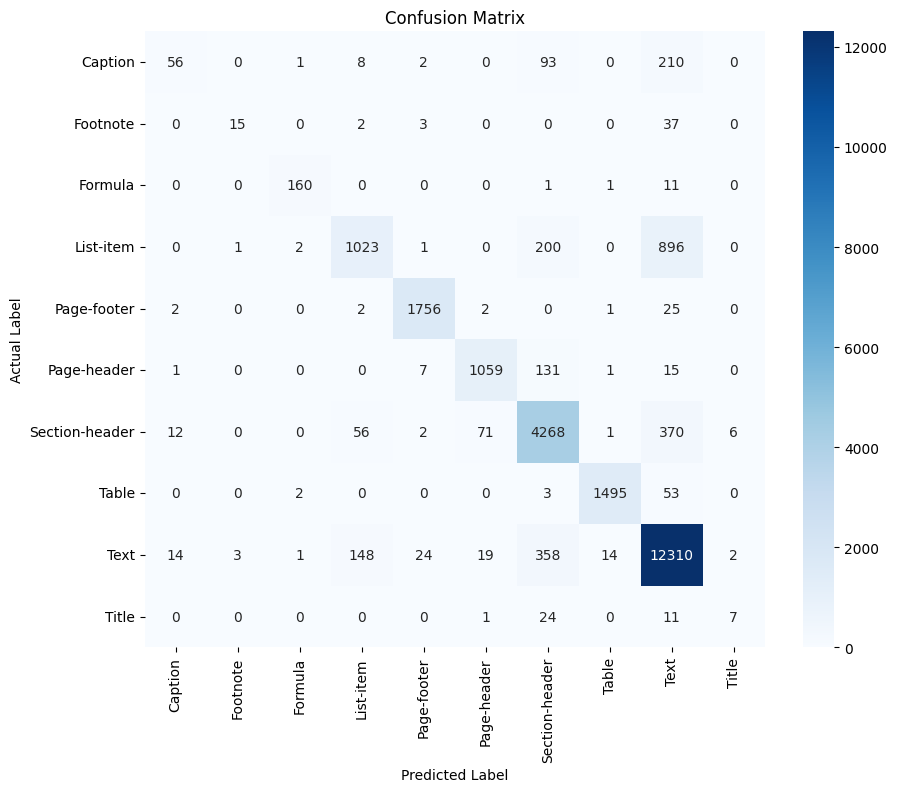


--- Model successfully saved to 'lightgbm_classifier_rich_features.txt' ---


In [6]:
# --- Cell 3 (Corrected with labels parameter) ---

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluating the model on the unseen test set...")

# Use the correct variable name 'lgb_classifier_gpu'
y_pred = lgb_classifier_gpu.predict(X_test)
y_pred_proba = lgb_classifier_gpu.predict_proba(X_test)

# Calculate final accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")

# --- Detailed Classification Report ---
print("\nClassification Report:")
label_to_idx = {name: idx for idx, name in enumerate([
    "Caption","Footnote","Formula","List-item","Page-footer",
    "Page-header","Section-header","Table","Text","Title"
])}
class_names = [name for name, idx in sorted(label_to_idx.items(), key=lambda item: item[1])]

# --- KEY CHANGE: Explicitly provide the full list of labels ---
# We create a list of all possible class indices (0 through 9).
all_labels = list(range(len(class_names)))
# This tells the report to build a row for every class, even if it's missing from y_test.
print(classification_report(
    y_test,
    y_pred,
    labels=all_labels, # Provide the full set of expected labels
    target_names=class_names
))
# -------------------------------------------------------------

# --- Confusion Matrix Visualization ---
print("Generating confusion matrix...")
# Use the same 'all_labels' to ensure the matrix axes are consistent
cm = confusion_matrix(y_test, y_pred, labels=all_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Save the Trained Model ---
MODEL_PATH = "lightgbm_classifier_rich_features.txt"
lgb_classifier_gpu.booster_.save_model(MODEL_PATH)

print(f"\n--- Model successfully saved to '{MODEL_PATH}' ---")

--- Starting Feature Importance Analysis ---


/tmp/ipython-input-7-45844931.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


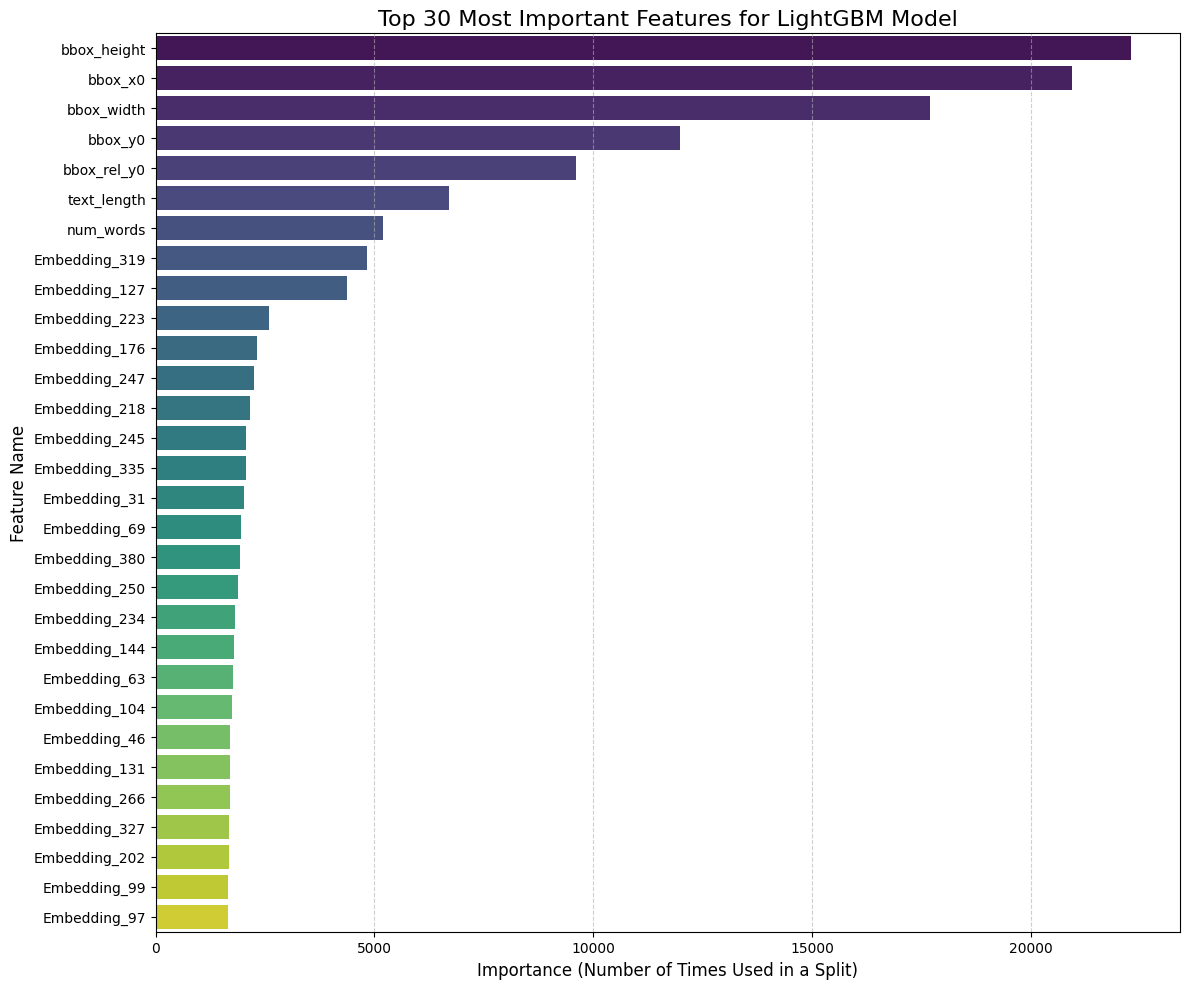


--- Quantitative Feature Analysis ---
Total importance from Numerical Features: 94437 (16.36%)
Total importance from Text Embeddings: 482819 (83.64%)

Most Important Numerical Features:
           feature  importance
387    bbox_height       22298
384        bbox_x0       20939
386     bbox_width       17701
385        bbox_y0       11995
388    bbox_rel_y0        9612
392    text_length        6694
391      num_words        5198
390  is_first_page           0
389        page_no           0


In [7]:
# --- Cell: Feature Importance Analysis ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Starting Feature Importance Analysis ---")

# This assumes 'lgb_classifier_gpu' is the trained model variable from the previous cell.

# --- 1. Reconstruct the Full List of Feature Names ---

# We know the first 384 columns are the text embeddings
embedding_feature_names = [f'Embedding_{i}' for i in range(384)]

# The rest are the numerical features you engineered
# This list MUST match the order used in Cell 1
numerical_feature_names = [
    'bbox_x0', 'bbox_y0', 'bbox_width', 'bbox_height', 'bbox_rel_y0',
    'page_no', 'is_first_page', 'num_words', 'text_length'
]

# Combine them into one list
full_feature_names = embedding_feature_names + numerical_feature_names

# --- 2. Get Feature Importances from the Trained Model ---

# LightGBM provides a built-in method to get importance scores
importances = lgb_classifier_gpu.feature_importances_

# Create a pandas DataFrame for easier manipulation and plotting
importance_df = pd.DataFrame({
    'feature': full_feature_names,
    'importance': importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# --- 3. Visualize the Top 30 Most Important Features ---

# Select the top N features for visualization
top_n = 30
top_features = importance_df.head(top_n)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Most Important Features for LightGBM Model', fontsize=16)
plt.xlabel('Importance (Number of Times Used in a Split)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# --- 4. Quantitative Analysis: What types of features are most important? ---

print("\n--- Quantitative Feature Analysis ---")

# Separate the importance scores for embedding vs. numerical features
numerical_importance = importance_df[importance_df['feature'].isin(numerical_feature_names)]
embedding_importance = importance_df[~importance_df['feature'].isin(numerical_feature_names)]

# Calculate the total importance contributed by each type
total_numerical_importance = numerical_importance['importance'].sum()
total_embedding_importance = embedding_importance['importance'].sum()
total_importance = total_numerical_importance + total_embedding_importance

print(f"Total importance from Numerical Features: {total_numerical_importance} ({total_numerical_importance / total_importance:.2%})")
print(f"Total importance from Text Embeddings: {total_embedding_importance} ({total_embedding_importance / total_importance:.2%})")

print("\nMost Important Numerical Features:")
print(numerical_importance.head(10))

In [13]:
# --- START OF FILE: run_inference.py (with final filtering logic) ---

import json
import lightgbm as lgb
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from pathlib import Path
import torch

# --- Configuration ---
INPUT_JSON_DIR = Path("input")
FINAL_OUTPUT_DIR = Path("predictions")
FINAL_OUTPUT_DIR.mkdir(exist_ok=True)
INPUT_JSON_DIR.mkdir(exist_ok=True)
MODEL_PATH = "lightgbm_classifier_rich_features.txt"
# --------------------


def predict_on_extracted_features(json_path, lgb_model, st_model):
    """
    Loads a JSON file with extracted features, runs predictions, and formats the output.
    """
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except (json.JSONDecodeError, FileNotFoundError):
        print(f"  → Could not read or find file: {json_path}, skipping.")
        return None

    if not data:
        print(f"  → No content found in {json_path}, skipping.")
        return None

    df = pd.DataFrame(data)

    # --- 1. Prepare the Feature Matrix (must match training) ---
    print(f"  → Generating text embeddings for {len(df)} blocks...")
    text_embeddings = st_model.encode(
        df['text'].tolist(),
        show_progress_bar=False,
        batch_size=128
    )
    numerical_feature_cols = [
        'bbox_x0', 'bbox_y0', 'bbox_width', 'bbox_height', 'bbox_rel_y0',
        'page_no', 'is_first_page', 'num_words', 'text_length'
    ]
    numerical_features = df[numerical_feature_cols].values
    X_inference = np.hstack((text_embeddings, numerical_features))

    # --- 2. Run Prediction (Corrected Method) ---
    print("  → Running model prediction...")
    predicted_probabilities = lgb_model.predict(X_inference)
    predicted_label_indices = np.argmax(predicted_probabilities, axis=1)

    # --- 3. Format the Output ---
    df['predicted_label_idx'] = predicted_label_indices
    df['label'] = df['predicted_label_idx'].map(id2label)

    # --- MODIFIED: ADDED FILTERING LOGIC ---
    # Define the labels you want to keep in the final output
    header_labels_to_keep = ["Page-header", "Section-header", "Title"]
    # Use pandas filtering to select only the rows with the desired labels
    filtered_df = df[df['label'].isin(header_labels_to_keep)]
    # ----------------------------------------

    # Select only the columns required for the final output from the filtered DataFrame
    output_df = filtered_df[['text', 'label', 'page_no']]

    return output_df.to_dict(orient='records')


if __name__ == "__main__":
    print("--- Initializing Inference Pipeline ---")
    id2label = {idx: name for idx, name in enumerate([
        "Caption","Footnote","Formula","List-item","Page-footer",
        "Page-header","Section-header","Table","Text","Title"
    ])}

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Loading SentenceTransformer model on device: '{device}'")
    sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

    print(f"Loading LightGBM model from: '{MODEL_PATH}'")
    try:
        lightgbm_model = lgb.Booster(model_file=MODEL_PATH)
    except lgb.basic.LightGBMError:
        print(f"\n[ERROR] Could not load model from '{MODEL_PATH}'.")
        print("Please ensure the model file exists and is in the correct location.")
        exit()

    print("--- Initialization Complete ---\n")

    json_files = list(INPUT_JSON_DIR.glob("*.json"))
    if not json_files:
        print(f"[WARNING] No JSON files found in '{INPUT_JSON_DIR}'. Please run extractor_v2.py first.")

    for json_path in json_files:
        print(f"Processing: {json_path.name}")
        predictions = predict_on_extracted_features(json_path, lightgbm_model, sentence_transformer_model)

        if predictions:
            out_file = FINAL_OUTPUT_DIR / f"{json_path.stem}_predictions.json"
            with open(out_file, "w", encoding="utf-8") as f:
                json.dump(predictions, f, ensure_ascii=False, indent=2)
            print(f"  → ✅ Saved predictions to {out_file}")

    print("\n--- All files processed. ---")

--- Initializing Inference Pipeline ---
Loading SentenceTransformer model on device: 'cuda'
Loading LightGBM model from: 'lightgbm_classifier_rich_features.txt'
--- Initialization Complete ---

Processing: E0H1CM114.json
  → Generating text embeddings for 18 blocks...
  → Running model prediction...
  → ✅ Saved predictions to predictions/E0H1CM114_predictions.json
Processing: Learn Acrobat - Create and Convert_1.json
  → Generating text embeddings for 38 blocks...
  → Running model prediction...
  → ✅ Saved predictions to predictions/Learn Acrobat - Create and Convert_1_predictions.json
Processing: TOPJUMP-PARTY-INVITATION-20161003-V01.json
  → Generating text embeddings for 14 blocks...
  → Running model prediction...
  → ✅ Saved predictions to predictions/TOPJUMP-PARTY-INVITATION-20161003-V01_predictions.json
Processing: E0CCG5S312.json
  → Generating text embeddings for 32 blocks...
  → Running model prediction...
  → ✅ Saved predictions to predictions/E0CCG5S312_predictions.json
Pr